# Final Embedding

## Purpose
The purpose of this step is to recalculate the embedding coordinates using consensus clustering labels and the Cluster Enriched Features (CEF) of each cluster.

## Input
- HVF adata file.
- Consensus cluster labels

## Output
- HVF adata file with updated embedding coordinates.

## Import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
from ALLCools.clustering import cluster_enriched_features, significant_pc_test, log_scale, balanced_pca, tsne
from ALLCools.plot import categorical_scatter

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [3]:
cell_metadata_path = 'CellMetadata.PassQC.csv.gz'
cluster_adata_path = 'adata.with_coords.h5ad'
ch_adata_path = 'mCH.HVF.h5ad'
cg_adata_path = 'mCG.HVF.h5ad'

# Cluster Enriched Features analysis
top_n=200
alpha=0.05
stat_plot=True

# you may provide a pre calculated cluster version. 
# If None, will perform basic clustering using parameters below.
cluster_col = 'L1'
p_cutoff = 0.1

## Load Data

In [4]:
adata = anndata.read_h5ad(cluster_adata_path)
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

## Cluster Enriched Features (CEF)

### mCH

Found 14 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 1651 unique features


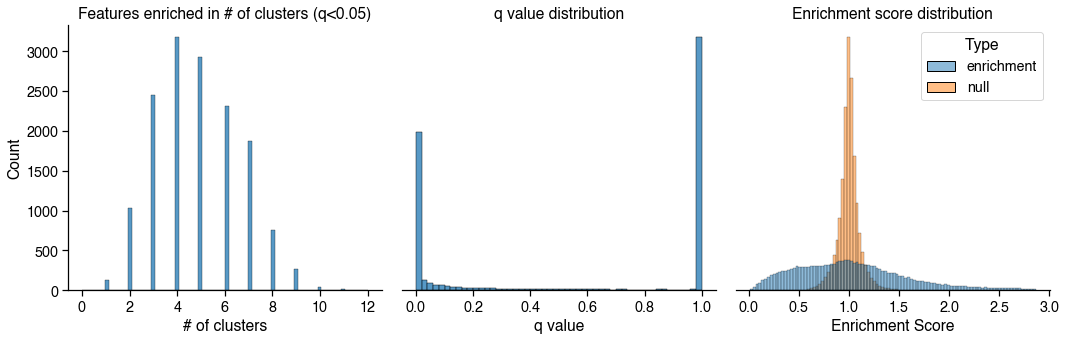

In [5]:
ch_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(ch_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

### mCG

Found 14 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 1863 unique features


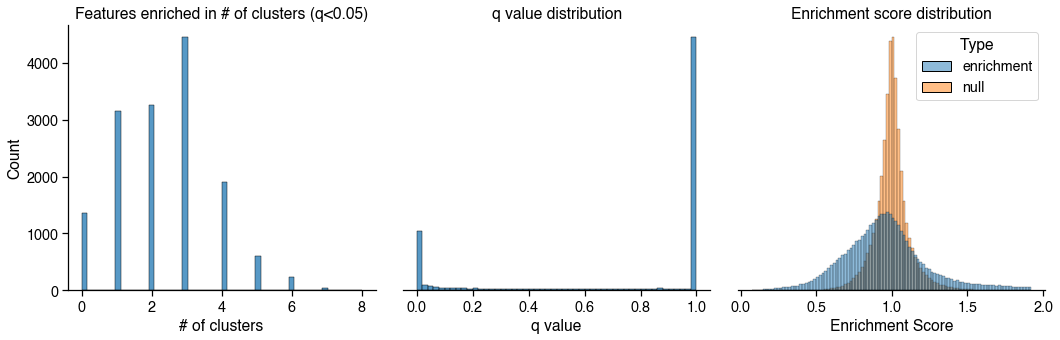

In [6]:
cg_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(cg_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

## Save AnnData

In [7]:
# save adata
ch_adata.write_h5ad(ch_adata_path)
cg_adata.write_h5ad(cg_adata_path)

# save CEF ids
with open(f'{cluster_col}_enriched_features.mCH.txt', 'w') as f:
    features = ch_adata.var_names[ch_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))
with open(f'{cluster_col}_enriched_features.mCG.txt', 'w') as f:
    features = cg_adata.var_names[cg_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))

## PCA

### mCH

In [8]:
# using Cluster Enriched Features
ch_adata = ch_adata[:, ch_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(ch_adata)
# PCA
balanced_pca(ch_adata, groups=cluster_col)
# Select significant PCs
ch_n_components = significant_pc_test(ch_adata, p_cutoff=p_cutoff)

adata.X is already log transformed, skip log step.
98 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4875, 100) to (4875, 98)


### mCG

In [9]:
# using Cluster Enriched Features
cg_adata = cg_adata[:, cg_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(cg_adata)
# PCA
balanced_pca(cg_adata, groups=cluster_col)
# Select significant PCs
cg_n_components = significant_pc_test(cg_adata, p_cutoff=p_cutoff)

adata.X is already log transformed, skip log step.
99 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (4875, 100) to (4875, 99)


### Concatenate

In [10]:
ch_pcs = ch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = cg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])
adata.obsm['X_pca'] = total_pcs

## Manifold Learning

### tSNE

In [11]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

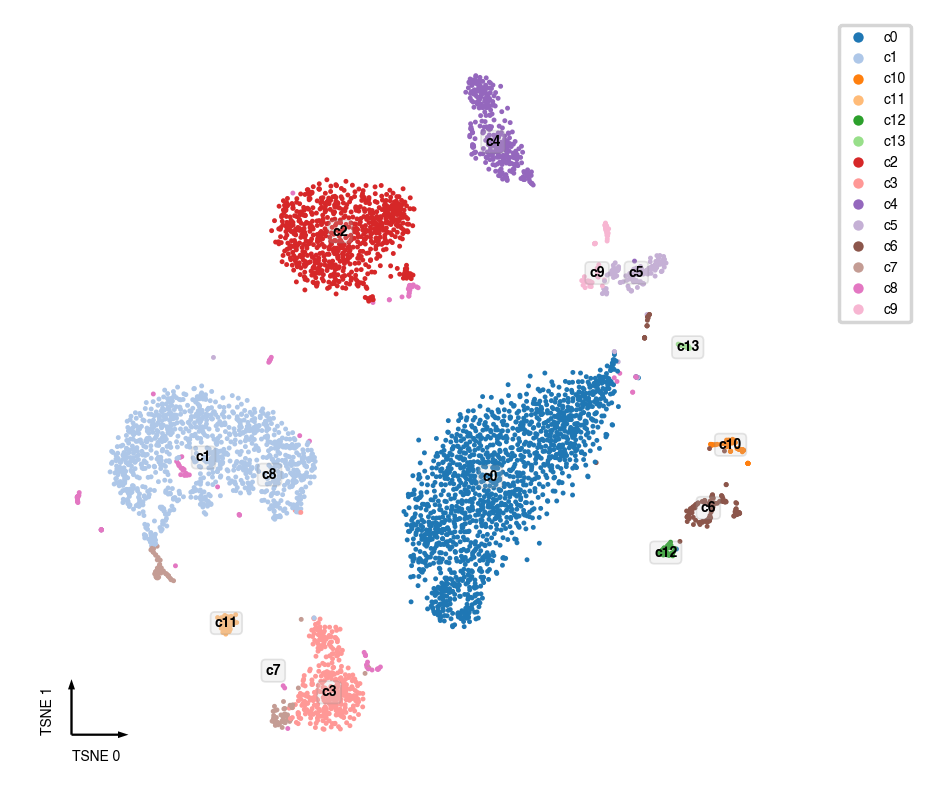

In [12]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=adata,
                    ax=ax,
                    coord_base='tsne',
                    hue=cluster_col,
                    show_legend=True,
                    text_anno=cluster_col,
                    s=2,
                    max_points=None)

### UMAP

In [13]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2022-08-09 14:25:27.015592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 14:25:27.015621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


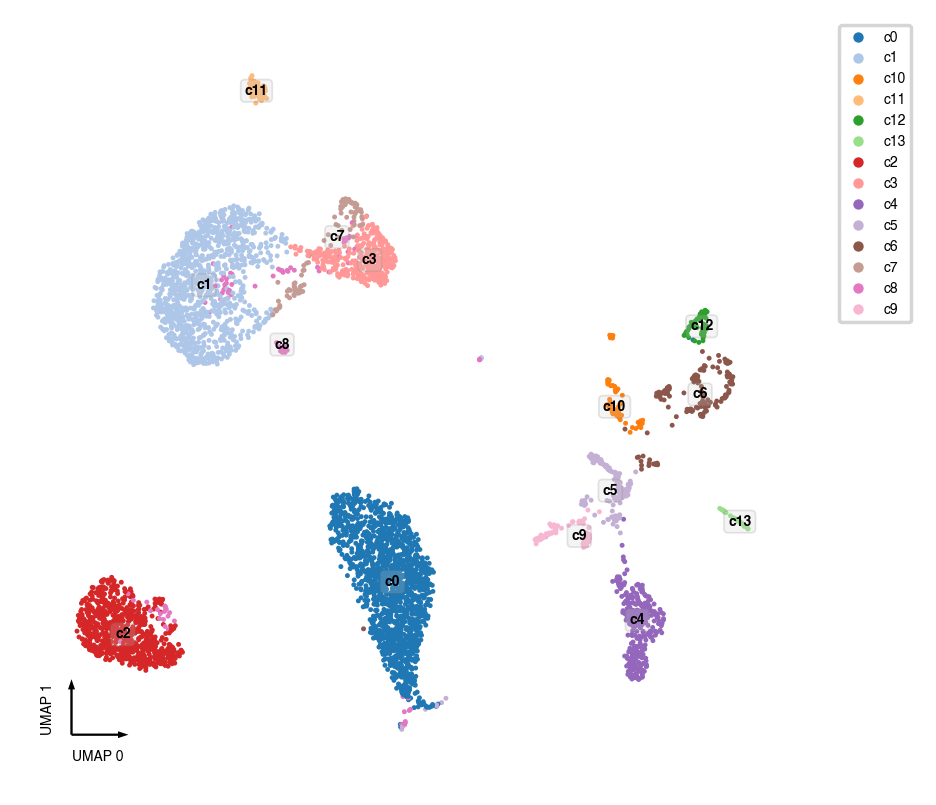

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=adata,
                    ax=ax,
                    coord_base='umap',
                    hue=cluster_col,
                    show_legend=True,
                    text_anno=cluster_col,
                    s=2,
                    max_points=None)

## Save

In [15]:
adata.write_h5ad('adata.with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 4875 × 2132
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'L1', 'L1_proba'
    var: 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'log', 'neighbors', 'umap', 'paga', 'L1_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [16]:
# save final clustering result table
cell_meta = pd.read_csv(cell_metadata_path, index_col=0)
final_result = pd.concat([cell_meta, adata.obs], axis=1, sort=True)
final_result.to_csv(f'{cluster_col}.ClusteringResults.csv.gz')
final_result.head()

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,...,Row384,FANSDate,Slice,Sample,leiden,mCHFrac,tsne_0,tsne_1,L1,L1_proba
8E_M_10,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.005505,0.744279,0.742863,0.020649,0.015228,2714916.0,6036476,4014048.0,8E,...,0,190711,8,8E_190711,8,0.020649,-7.646137,16.721509,c8,0.549360
8E_M_100,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-1...,0.004702,0.723100,0.721792,0.012400,0.007735,3302547.0,7683706,5370970.0,8E,...,2,190711,8,8E_190711,7,0.012400,5.817251,25.264501,c8,0.395962
8E_M_1000,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005423,0.739960,0.738542,0.021733,0.016399,1369094.0,3658050,2381916.0,8E,...,5,190711,8,8E_190711,8,0.021733,-26.855708,14.451151,c1,0.921800
8E_M_1002,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.004117,0.745511,0.744459,0.010192,0.006101,4571390.0,11822434,8079217.0,8E,...,5,190711,8,8E_190711,15,0.010192,29.288899,24.082294,c4,0.899333
8E_M_1003,/gale/raidix/rdx-4/mapping/8E/CEMBA190711-8E-3...,0.005528,0.750461,0.749074,0.023083,0.017652,1334845.0,3479288,2337068.0,8E,...,4,190711,8,8E_190711,3,0.023083,-12.959669,1.623964,c1,0.554967
